<a href="https://colab.research.google.com/github/Devoteng1/Apache-Spark-Multi-Classifier/blob/main/MulticlassProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#Update system packages
!sudo apt-get update

In [2]:
#install Java
!sudo apt install default-jdk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  default-jdk-headless openjdk-11-jdk
Suggested packages:
  openjdk-11-demo openjdk-11-source visualvm
The following NEW packages will be installed:
  default-jdk default-jdk-headless openjdk-11-jdk
0 upgraded, 3 newly installed, 0 to remove and 66 not upgraded.
Need to get 1,556 kB of archives.
After this operation, 1,614 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 default-jdk-headless amd64 2:1.11-68ubuntu1~18.04.1 [1,132 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 openjdk-11-jdk amd64 11.0.15+10-0ubuntu0.18.04.1 [1,554 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 default-jdk amd64 2:1.11-68

In [ ]:
# Download Apache Spark and extract
!wget https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xvf spark-3.0.3-bin-hadoop2.7.tgz

In [ ]:
#Install pyspark
!pip install -q findspark
!pip install pyspark

In [5]:
#setting the environment path 
import os
from os.path import abspath
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
# warehouse_location points to the default location for managed databases and tables
warehouse_location = abspath('spark-warehouse')

In [6]:
#Running a local SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from sklearn.metrics import classification_report,confusion_matrix
from pyspark.ml.stat import Correlation,ChiSquareTest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [7]:
spark = SparkSession.builder.appName('multiclass').getOrCreate()

In [8]:
data = spark.read.options(header='True', inferSchema='True', delimiter=';').csv('education.csv')

In [9]:
data.show()

+--------------+----------------+-----------------+------+--------------------------+----------------------+-----------+----------------------+----------------------+-------------------+-------------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------+--------------+-----+--------+
|Marital status|Application mode|Application order|Course|Daytime/evening attendance|Previous qualification|Nacionality|Mother's qualification|Father's qualification|

In [11]:
data.select('target').distinct().show()

+--------+
|  target|
+--------+
|Enrolled|
| Dropout|
|Graduate|
+--------+



In [12]:
data.dtypes

[('Marital status', 'int'),
 ('Application mode', 'int'),
 ('Application order', 'int'),
 ('Course', 'int'),
 ('Daytime/evening attendance', 'int'),
 ('Previous qualification', 'int'),
 ('Nacionality', 'int'),
 ("Mother's qualification", 'int'),
 ("Father's qualification", 'int'),
 ("Mother's occupation", 'int'),
 ("Father's occupation", 'int'),
 ('Displaced', 'int'),
 ('Educational special needs', 'int'),
 ('Debtor', 'int'),
 ('Tuition fees up to date', 'int'),
 ('Gender', 'int'),
 ('Scholarship holder', 'int'),
 ('Age at enrollment', 'int'),
 ('International', 'int'),
 ('Curricular units 1st sem (credited)', 'int'),
 ('Curricular units 1st sem (enrolled)', 'int'),
 ('Curricular units 1st sem (evaluations)', 'int'),
 ('Curricular units 1st sem (approved)', 'int'),
 ('Curricular units 1st sem (grade)', 'double'),
 ('Curricular units 1st sem (without evaluations)', 'int'),
 ('Curricular units 2nd sem (credited)', 'int'),
 ('Curricular units 2nd sem (enrolled)', 'int'),
 ('Curricular uni

In [13]:
#get dimension of data
(data.count() , len(data.columns))

(4424, 35)

In [16]:
data.select('target').groupBy('target').count().orderBy(col('count').desc()).show()

+--------+-----+
|  target|count|
+--------+-----+
|Graduate| 2209|
| Dropout| 1421|
|Enrolled|  794|
+--------+-----+



In [17]:
data.printSchema()

root
 |-- Marital status: integer (nullable = true)
 |-- Application mode: integer (nullable = true)
 |-- Application order: integer (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime/evening attendance: integer (nullable = true)
 |-- Previous qualification: integer (nullable = true)
 |-- Nacionality: integer (nullable = true)
 |-- Mother's qualification: integer (nullable = true)
 |-- Father's qualification: integer (nullable = true)
 |-- Mother's occupation: integer (nullable = true)
 |-- Father's occupation: integer (nullable = true)
 |-- Displaced: integer (nullable = true)
 |-- Educational special needs: integer (nullable = true)
 |-- Debtor: integer (nullable = true)
 |-- Tuition fees up to date: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Scholarship holder: integer (nullable = true)
 |-- Age at enrollment: integer (nullable = true)
 |-- International: integer (nullable = true)
 |-- Curricular units 1st sem (credited): integer (nullab

In [18]:
data.count(),data.distinct().count()

(4424, 4424)

In [19]:
#check null value count in your dataset
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show(truncate=False)

+--------------+----------------+-----------------+------+--------------------------+----------------------+-----------+----------------------+----------------------+-------------------+-------------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------+--------------+---+------+
|Marital status|Application mode|Application order|Course|Daytime/evening attendance|Previous qualification|Nacionality|Mother's qualification|Father's qualification|Moth

In [20]:
#Exploratory Data Analysis
data.summary().show(truncate=False)

+-------+------------------+-----------------+------------------+-----------------+--------------------------+----------------------+------------------+----------------------+----------------------+-------------------+-------------------+-------------------+-------------------------+-------------------+-----------------------+-------------------+-------------------+------------------+--------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+------------------+------------------+---------------------+--------+
|summary|Marital status    |Application mode |Application order |Cou

In [21]:
data.describe().show(truncate=False)

+-------+------------------+-----------------+------------------+-----------------+--------------------------+----------------------+------------------+----------------------+----------------------+-------------------+-------------------+-------------------+-------------------------+-------------------+-----------------------+-------------------+-------------------+------------------+--------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+------------------+------------------+---------------------+--------+
|summary|Marital status    |Application mode |Application order |Cou

In [26]:
pd = data.toPandas()

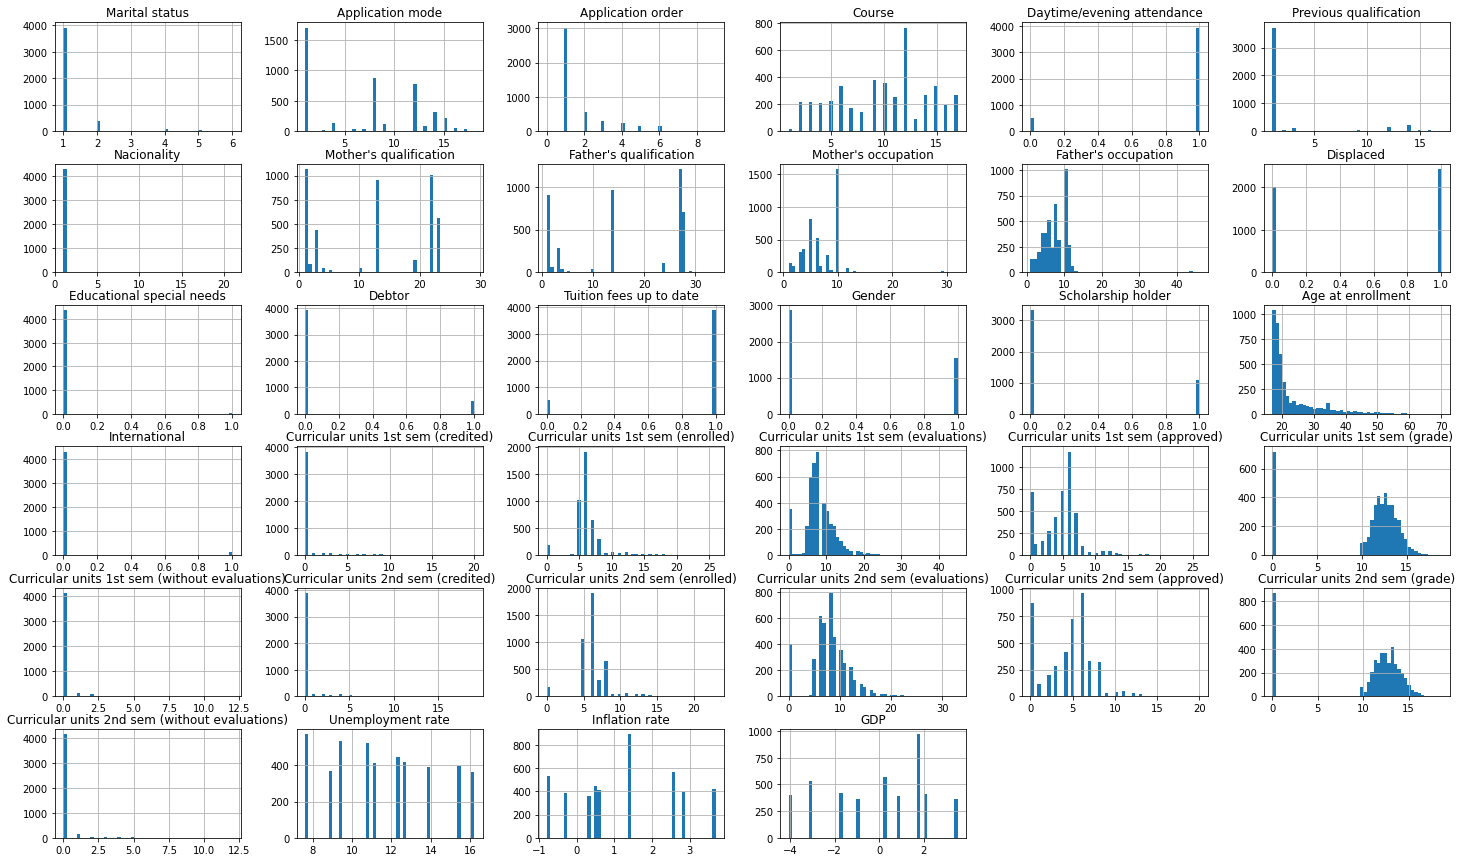

In [27]:
pd.hist(bins=50, figsize=(25,15))
plt.show()

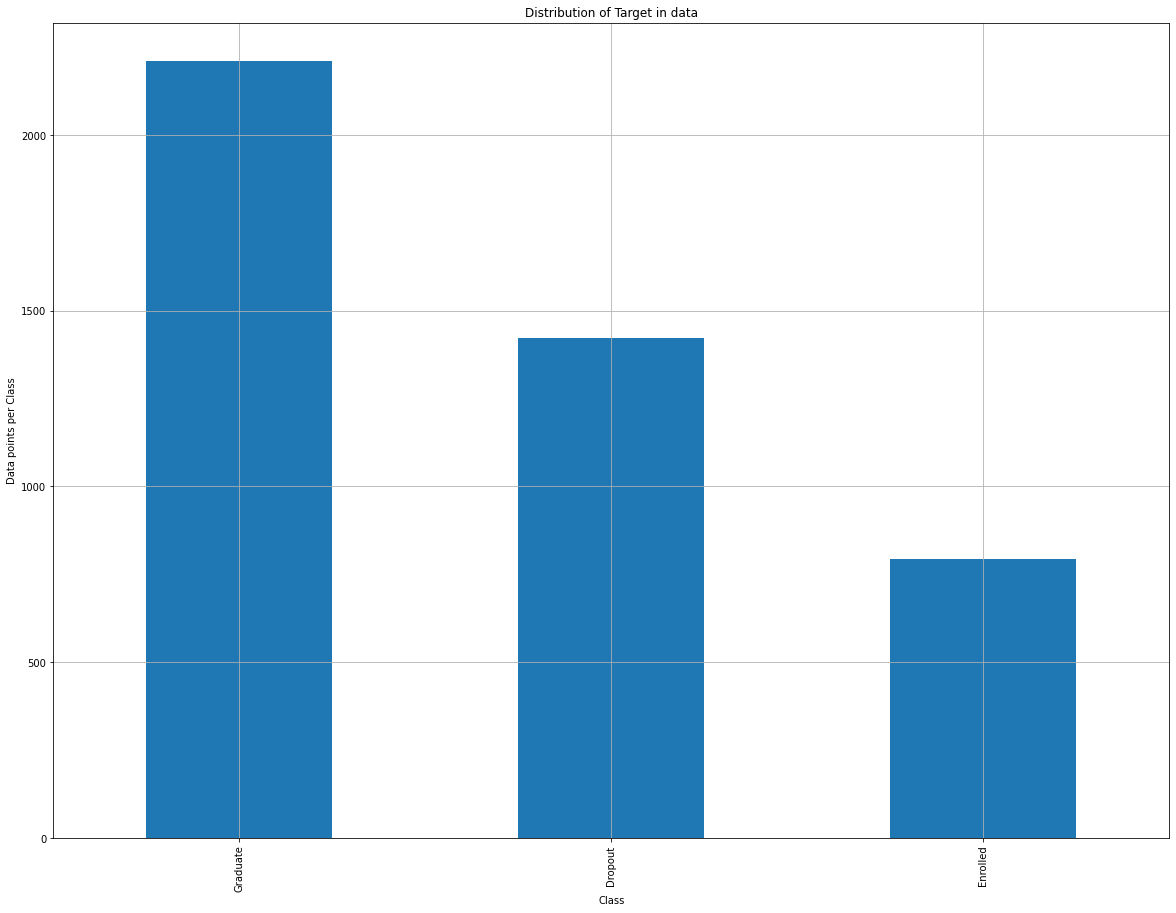

Number of data points in class 1 : 2209 ( 49.932 %)
Number of data points in class 2 : 1421 ( 32.12 %)
Number of data points in class 3 : 794 ( 17.948 %)


In [29]:
plt.figure(figsize=(20,15))
class_distribution = pd['Target'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Target in data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1,':', class_distribution.values[i], '(', np.round((class_distribution.values[i]/pd.shape[0]*100), 3), '%)')

In [30]:

data.createOrReplaceTempView("edudata")

In [31]:
class_categories = spark.sql('select distinct(trim(Target)) as class_categories, \
           count(*) as total \
           from edudata \
           group by Target \
           order by total desc')

class_categories.show(25)

+----------------+-----+
|class_categories|total|
+----------------+-----+
|        Graduate| 2209|
|         Dropout| 1421|
|        Enrolled|  794|
+----------------+-----+



In [32]:
class_data  = class_categories.toPandas()

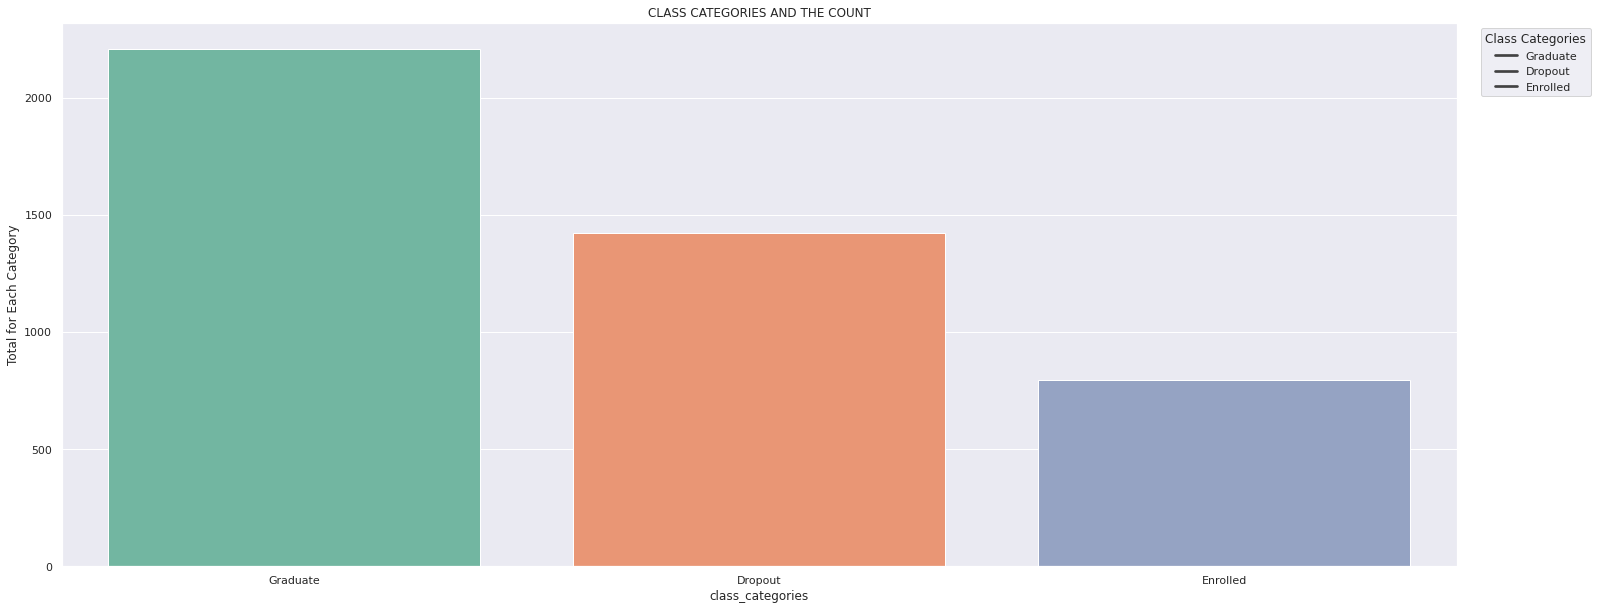

In [34]:
fig, ax = plt.subplots(figsize=(25,10))
sns.set(style="darkgrid")
ax = sns.barplot(data=class_data, x='class_categories',y='total', palette= 'Set2')
ax.set_ylabel("Total for Each Category")
ax.set_title("CLASS CATEGORIES AND THE COUNT")
ax.legend(labels = ["Graduate","Dropout","Enrolled"],title="Class Categories",bbox_to_anchor= (1.10, 1) )
plt.show()

In [39]:
 corr = pd.corr(method="pearson").round(2)
 corr

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
Marital status,1.00,0.22,-0.13,0.02,-0.27,0.12,-0.02,0.19,0.13,0.07,...,0.03,0.06,0.04,0.02,-0.04,-0.07,0.02,-0.02,0.01,-0.03
Application mode,0.22,1.00,-0.25,-0.09,-0.27,0.43,-0.00,0.09,0.07,0.03,...,0.04,0.23,0.13,0.16,-0.07,-0.10,0.04,0.09,-0.02,-0.01
Application order,-0.13,-0.25,1.00,0.12,0.16,-0.20,-0.03,-0.06,-0.05,-0.05,...,-0.03,-0.13,0.03,-0.06,0.07,0.06,-0.02,-0.10,-0.01,0.03
Course,0.02,-0.09,0.12,1.00,-0.07,-0.16,-0.00,0.06,0.05,0.03,...,-0.06,-0.12,0.19,0.05,0.12,0.18,-0.01,-0.05,0.03,-0.01
Daytime/evening attendance,-0.27,-0.27,0.16,-0.07,1.00,-0.10,0.02,-0.20,-0.14,-0.04,...,0.05,-0.11,0.00,0.01,0.03,0.05,-0.00,0.06,-0.02,0.02
Previous qualification,0.12,0.43,-0.20,-0.16,-0.10,1.00,-0.04,0.02,0.01,0.01,...,0.02,0.14,0.06,0.10,-0.04,-0.04,0.02,0.10,-0.06,0.05
Nacionality,-0.02,-0.00,-0.03,-0.00,0.02,-0.04,1.00,-0.04,-0.09,0.04,...,0.03,-0.00,-0.02,-0.02,-0.01,-0.01,-0.01,-0.01,-0.01,0.04
Mother's qualification,0.19,0.09,-0.06,0.06,-0.20,0.02,-0.04,1.00,0.52,0.30,...,0.00,0.04,0.03,0.02,-0.01,-0.03,0.02,-0.11,0.06,-0.08
Father's qualification,0.13,0.07,-0.05,0.05,-0.14,0.01,-0.09,0.52,1.00,0.21,...,-0.02,0.04,0.02,0.01,0.01,-0.01,-0.01,-0.08,0.06,-0.07
Mother's occupation,0.07,0.03,-0.05,0.03,-0.04,0.01,0.04,0.30,0.21,1.00,...,-0.01,-0.00,0.01,0.01,0.02,0.04,-0.00,-0.01,0.02,0.09


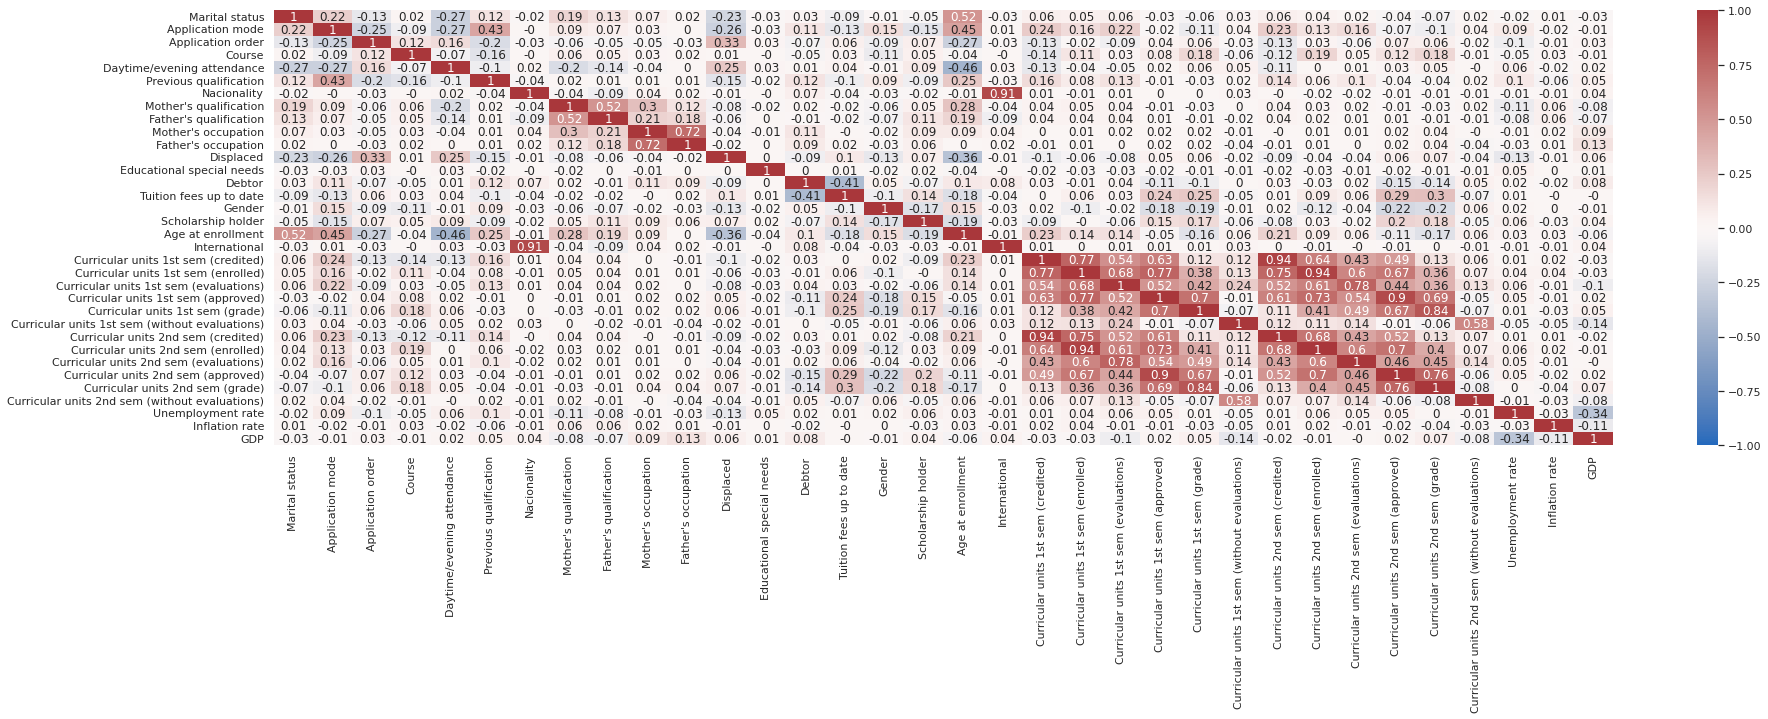

In [40]:
fig, ax = plt.subplots(figsize = (30,8))
sns.heatmap(corr,annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.savefig('heatmap.png')

In [41]:
categorical_features = [item[0] for item in data.dtypes if item[1].startswith('string')]
print(categorical_features)

['Target']


In [42]:
#convert categorical data into numeric using the StrinIndexer
SI_Target = StringIndexer(inputCol="Target", outputCol="Target_Index")


In [43]:
pipe = Pipeline(stages = [SI_Target])

In [44]:
data = pipe.fit(data).transform(data)

In [45]:
data.select('Target_Index').distinct().show()

+------------+
|Target_Index|
+------------+
|         0.0|
|         1.0|
|         2.0|
+------------+



In [46]:
data.select('Target_Index', 'Target').show()

+------------+--------+
|Target_Index|  Target|
+------------+--------+
|         1.0| Dropout|
|         0.0|Graduate|
|         1.0| Dropout|
|         0.0|Graduate|
|         0.0|Graduate|
|         0.0|Graduate|
|         0.0|Graduate|
|         1.0| Dropout|
|         0.0|Graduate|
|         1.0| Dropout|
|         0.0|Graduate|
|         0.0|Graduate|
|         1.0| Dropout|
|         0.0|Graduate|
|         0.0|Graduate|
|         1.0| Dropout|
|         2.0|Enrolled|
|         0.0|Graduate|
|         0.0|Graduate|
|         2.0|Enrolled|
+------------+--------+
only showing top 20 rows



In [47]:
cols = data.columns
cols.remove("Target_Index")
cols.remove("Target")
cols

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation",
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rate',
 'GDP']

In [48]:
assembler = VectorAssembler(inputCols=cols,outputCol="features")

In [49]:
data_v=assembler.transform(data)
data_v.show(3)


+--------------+----------------+-----------------+------+--------------------------+----------------------+-----------+----------------------+----------------------+-------------------+-------------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------+--------------+----+--------+------------+--------------------+
|Marital status|Application mode|Application order|Course|Daytime/evening attendance|Previous qualification|Nacionality|Mother's qual

In [50]:
data_v.select("features", "Target_Index").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                       |Target_Index|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|(34,[0,1,2,3,4,5,6,7,8,9,10,11,14,15,17,31,32,33],[1.0,8.0,5.0,2.0,1.0,1.0,1.0,13.0,10.0,6.0,10.0,1.0,1.0,1.0,20.0,10.8,1.4,1.74])                                             |1.0         |
|[1.0,6.0,1.0,11.0,1.0,1.0,1.0,1.0,3.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,19.0,0.0,0.0,6.0,6.0,6.0,14.0,0.0,0.0,6.0,6.0,6.0,13.666666666666666,0.0,13.9,-0.3,0.79]                 |0.0         |
|(34,[0,1,2,3,4,5,6,7,8,9,10,11,15,17,20,26,3

In [52]:
from pyspark.ml.feature import MinMaxScaler
MinMaxScaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
final_data=MinMaxScaler.fit(data_v).transform(data_v)

In [53]:
final_data.select("features","scaledFeatures", "Target_Index").show()

+--------------------+--------------------+------------+
|            features|      scaledFeatures|Target_Index|
+--------------------+--------------------+------------+
|(34,[0,1,2,3,4,5,...|(34,[1,2,3,4,7,8,...|         1.0|
|[1.0,6.0,1.0,11.0...|(34,[1,2,3,4,8,9,...|         0.0|
|(34,[0,1,2,3,4,5,...|(34,[2,3,4,7,8,9,...|         1.0|
|[1.0,8.0,2.0,15.0...|(34,[1,2,3,4,7,8,...|         0.0|
|[2.0,12.0,1.0,3.0...|(34,[0,1,2,3,7,8,...|         0.0|
|[2.0,12.0,1.0,17....|[0.2,0.6470588235...|         0.0|
|[1.0,1.0,1.0,12.0...|(34,[2,3,4,7,8,9,...|         0.0|
|(34,[0,1,2,3,4,5,...|(34,[1,2,3,4,7,8,...|         1.0|
|[1.0,1.0,3.0,10.0...|(34,[2,3,4,6,9,10...|         0.0|
|[1.0,1.0,1.0,10.0...|(34,[2,3,4,8,9,10...|         1.0|
|[1.0,1.0,1.0,14.0...|(34,[2,3,4,7,8,9,...|         0.0|
|[1.0,1.0,1.0,12.0...|[0.0,0.0,0.111111...|         0.0|
|(34,[0,1,2,3,4,5,...|(34,[2,3,4,7,8,9,...|         1.0|
|[1.0,17.0,1.0,11....|[0.0,0.9411764705...|         0.0|
|[1.0,1.0,1.0,6.0,...|[0.0,0.0,

In [55]:
train_data, test_data = final_data.randomSplit([0.7, 0.3])

In [56]:
train_data.select("scaledFeatures","Target_Index").show()

+--------------------+------------+
|      scaledFeatures|Target_Index|
+--------------------+------------+
|(34,[2,3,4,9,10,1...|         1.0|
|(34,[2,3,4,9,10,1...|         0.0|
|[0.0,0.0,0.111111...|         0.0|
|[0.0,0.0,0.111111...|         2.0|
|[0.0,0.0,0.111111...|         2.0|
|[0.0,0.0,0.111111...|         0.0|
|(34,[2,3,4,8,9,10...|         0.0|
|(34,[2,3,4,8,9,10...|         0.0|
|(34,[2,3,4,8,9,10...|         1.0|
|(34,[2,3,4,8,9,10...|         1.0|
|(34,[2,3,4,8,9,10...|         0.0|
|(34,[2,3,4,8,9,10...|         2.0|
|(34,[2,3,4,8,9,10...|         1.0|
|(34,[2,3,4,7,8,9,...|         2.0|
|[0.0,0.0,0.111111...|         0.0|
|(34,[2,3,4,7,9,10...|         0.0|
|(34,[2,3,4,7,9,10...|         0.0|
|(34,[2,3,4,7,9,10...|         1.0|
|(34,[2,3,4,7,8,9,...|         2.0|
|(34,[2,3,4,7,8,9,...|         0.0|
+--------------------+------------+
only showing top 20 rows



In [57]:
test_data.select("scaledFeatures","Target_Index").show()

+--------------------+------------+
|      scaledFeatures|Target_Index|
+--------------------+------------+
|(34,[2,3,4,9,10,1...|         0.0|
|(34,[2,3,4,9,10,1...|         1.0|
|(34,[2,3,4,9,10,1...|         0.0|
|(34,[2,3,4,9,10,1...|         1.0|
|[0.0,0.0,0.111111...|         2.0|
|(34,[2,3,4,9,10,1...|         0.0|
|[0.0,0.0,0.111111...|         0.0|
|(34,[2,3,4,8,9,10...|         0.0|
|(34,[2,3,4,8,9,10...|         2.0|
|(34,[2,3,4,8,9,10...|         0.0|
|(34,[2,3,4,8,9,10...|         0.0|
|(34,[2,3,4,8,9,10...|         1.0|
|(34,[2,3,4,8,9,10...|         0.0|
|(34,[2,3,4,7,8,9,...|         2.0|
|(34,[2,3,4,7,8,9,...|         1.0|
|(34,[2,3,4,7,8,9,...|         0.0|
|(34,[2,3,4,7,8,9,...|         2.0|
|(34,[2,3,4,7,8,9,...|         1.0|
|(34,[2,3,4,7,8,9,...|         0.0|
|(34,[2,3,4,7,8,9,...|         1.0|
+--------------------+------------+
only showing top 20 rows



In [58]:
train_data.count(), test_data.count()

(3063, 1361)

In [59]:
#Feature selection
# Feature selection using chisquareSelector
from pyspark.ml.feature import ChiSqSelector

In [61]:
css = ChiSqSelector(featuresCol="scaledFeatures",outputCol='selectedFeatures',labelCol='Target_Index',fpr=0.05)
train = css.fit(train_data).transform(train_data)
test = css.fit(test_data).transform(test_data)

In [62]:
train.select("selectedFeatures").show(5,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|selectedFeatures                                                                                                                                                                                                                                                                                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [63]:
test.select("selectedFeatures").show(5,truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|selectedFeatures                                                                                                                                                                                                                                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [64]:
#Building a classification model using Logistic Regression (LR)
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Target_Index", featuresCol="selectedFeatures",family="multinomial")
model=lr.fit(train)


In [65]:
#prediction
pred =model.transform(test)
pred.select("Target_Index","prediction").show(100)

+------------+----------+
|Target_Index|prediction|
+------------+----------+
|         0.0|       0.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         1.0|       0.0|
|         2.0|       1.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         2.0|       1.0|
|         0.0|       1.0|
|         0.0|       0.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         2.0|       0.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         2.0|       0.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         1.0|       0.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.

In [66]:
#Evaluating the model
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
model_accuracy = MulticlassClassificationEvaluator(metricName="accuracy",labelCol="Target_Index").evaluate(pred)
print('The Model Accuracy is, ', model_accuracy)
pred.select("Target_Index","rawPrediction","prediction","probability").show(5)

The Model Accuracy is,  0.7854518736223365
+------------+--------------------+----------+--------------------+
|Target_Index|       rawPrediction|prediction|         probability|
+------------+--------------------+----------+--------------------+
|         0.0|[0.27308497089559...|       0.0|[0.42669428751921...|
|         1.0|[-0.0070171762535...|       1.0|[0.32368461729650...|
|         0.0|[0.18925416105107...|       0.0|[0.39907655376303...|
|         1.0|[0.65619960566965...|       0.0|[0.57178591598388...|
|         2.0|[-3.1363278001571...|       1.0|[0.00399825418575...|
+------------+--------------------+----------+--------------------+
only showing top 5 rows



In [67]:
def plot_confusion_matrix(data, labels, output_filename):
    sns.set(color_codes=True)
    plt.figure(1, figsize=(30,9))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.5)
    ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", cbar_kws={'label': 'Scale'}, fmt='.2%')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [68]:
actual = pred.select('Target_Index').distinct().toPandas()
pred = pred.select('prediction').distinct().toPandas()

In [70]:
cnmatrix_final = confusion_matrix(actual, pred)

In [71]:
class_temp = data.select("Target").groupBy("Target")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["Target"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
multi_labels = class_temp

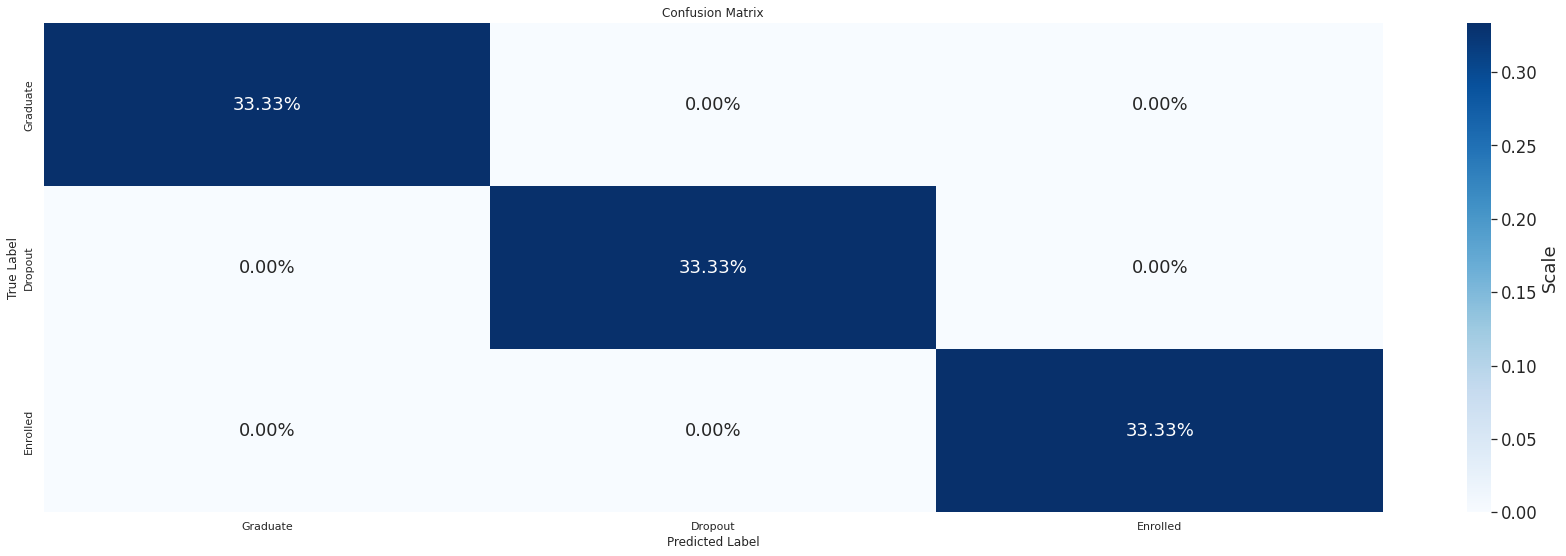

In [72]:
plot_confusion_matrix(cnmatrix_final,multi_labels, 'test.png')

In [73]:
print(classification_report(actual, pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         1
         2.0       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

